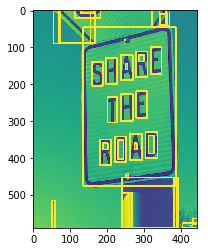

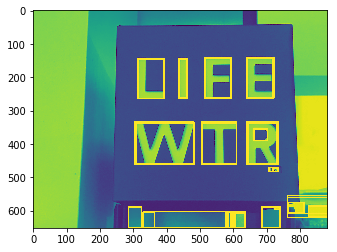

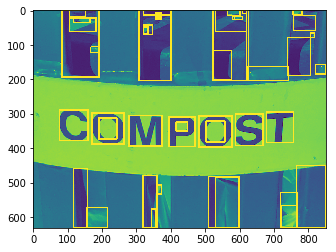

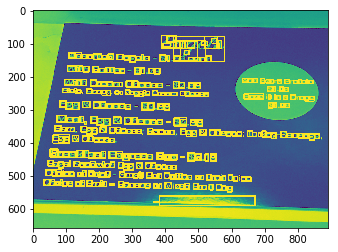

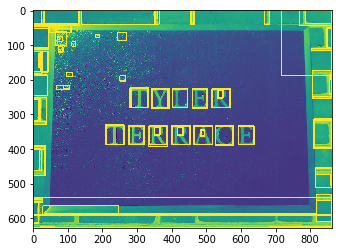

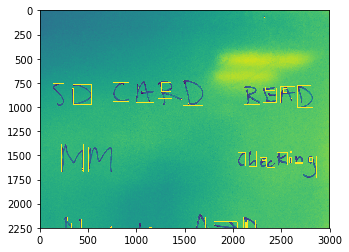

In [2]:
import matplotlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def auto_canny(img, sigma=0.33):
    median = np.median(img)
    lower = int(max(0, (1 - sigma)* sigma))
    upper = int(min(255, (1 + sigma)* sigma))

    return cv2.Canny(img, lower, upper)


mser = cv2.MSER_create()
image_letters = []
for i in range(1,7):
    image_letters.append([])
    img = cv2.imread('image' + str(i) + '.png')
#     print(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    vis = img_gray.copy()
    # vis = cv2.Canny(img_gray, 30, 200)
    # plt.imshow(vis)
    # plt.show()
    img_gray = cv2.GaussianBlur(img_gray, (3,3), 0)
    # regions = mser.detectRegions(vis)
    regions, _ = mser.detectRegions(img_gray)
    # i = 1
    for region in regions:

        region = np.array(region)
        minX = np.min(region[:, 0])
        maxX = np.max(region[:, 0])
        highestY = np.min(region[:, 1])
        lowestY = np.max(region[:, 1])
        
        if min([minX,maxX,highestY,lowestY]) < 0 or max([minX,maxX]) > img.shape[1] or max([highestY,lowestY]) > img.shape[0]:
            continue

        image_letters[-1].append((None, minX, lowestY, maxX, highestY))

        cv2.rectangle(vis, (maxX, lowestY), (minX, highestY), (255, 0, 0), 2)

    # hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

    plt.imshow(vis)
    plt.show()

images_folder = 'images_cropped'
if not os.path.exists(images_folder):
    os.mkdir(images_folder)
image_paths = []
for i,letters in enumerate(image_letters, 1):
    image_file = 'image' + str(i) + '.png'
    image_folder = 'image' + str(i)
    img = cv2.imread(image_file)
    if not os.path.exists(os.path.join(images_folder,image_folder)):
        os.mkdir(os.path.join(images_folder,image_folder))
    for j,letter in enumerate(letters):
#         plt.imshow(img[letter[1]:letter[3],letter[2]:letter[4]])
#         plt.show()
        image_path = os.path.join(images_folder,image_folder,'image'+str(j)+'.png')
        image_paths.append(image_path)
        cv2.imwrite(image_path, img[letter[4]:letter[2],letter[1]:letter[3]])
        
with open('images.txt', 'w') as f:
    for path in image_paths:
        f.write(path+'\n')
    
with open('image_letter_positions.txt', 'w') as f:
    for letters in image_letters:
        f.write(str(letters)+'\n')

image0
10
(255, 0, 0)
(13.277777777777779, 1.3252067157640626)
(230, 25, 0)
(12.6875, 0.94991775959816649)
(204, 51, 0)
(39.632810095413973, 1.150553875721777)
(179, 76, 0)
(40.010989010989015, 4.1804389384163905)
(153, 102, 0)
(41.390031152647978, 0.51910968901265231)
(128, 127, 0)
(102, 153, 0)
(77, 178, 0)
(199.33333333333334, 0.47140452079103168)
(51, 204, 0)
(26, 229, 0)
image1
6
(255, 0, 0)
(95.927272727272722, 0.67026576695151863)
(213, 42, 0)
(170, 85, 0)
(129.875, 0.80687153045987847)
(128, 127, 0)
(15.25, 0.4330127018922193)
(85, 170, 0)
(33.100000000000001, 1.9209372712298547)
(43, 212, 0)
(42.0, 0.0)
image2
14
(255, 0, 0)
(30.833333333333332, 0.68718427093627676)
(237, 18, 0)
(219, 36, 0)
(201, 54, 0)
(216.5, 1.8419709940325182)
(183, 72, 0)
(164, 91, 0)
(146, 109, 0)
(128, 127, 0)
(110, 145, 0)
(92, 163, 0)
(89.444444444444443, 0.4969039949999533)
(73, 182, 0)
(55, 200, 0)
(11.25, 0.82915619758884995)
(37, 218, 0)
(19, 236, 0)
(164.0, 0.0)
image3
10
(255, 0, 0)
(422.223958

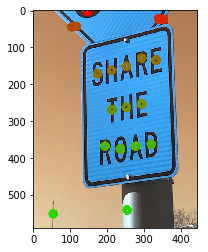

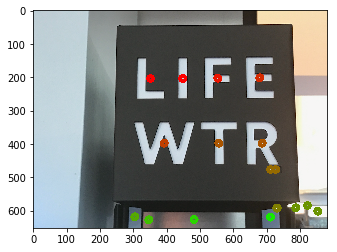

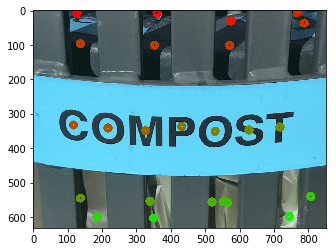

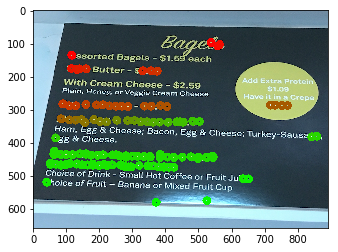

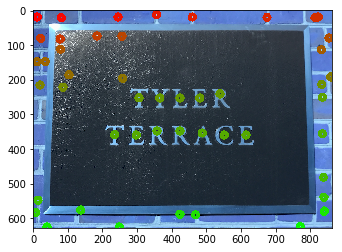

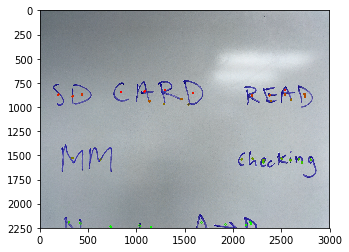

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans
import cv2

class Word:
    def __init__(self):
        self.letters = []
        self.minx = None
        self.miny = None
        self.maxx = None
        self.maxy = None
        
    def append(self, letter):
        self.letters.append(letter)
        self.update_box()
        
    def update_box(self):
        self.minx = min([min(letter.x1,letter.x2) for letter in self.letters])
        self.miny = min([min(letter.y1,letter.y2) for letter in self.letters])
        self.maxx = max([max(letter.x1,letter.x2) for letter in self.letters])
        self.maxy = max([max(letter.y1,letter.y2) for letter in self.letters])
        
    def position(self):
        self.update_box()
        return [(self.minx + self.maxx)/2, (self.miny+self.maxy)/2]
    
    def add_letters(self, letters, mean, std):
        letters = sorted(letters, key=lambda x:x.position()[0])
        for letter in letters:
            if letter.position()[0] > self.letters[-1].position()[0]+mean-2*std \
                and letter.position()[0] < self.letters[-1].position()[0]+mean+2*std:
                self.append(letter)
    
    def __str__(self):
        final_string = ""
        for letter in self.letters:
            final_string += str(letter)
        return final_string
    
class Letter:
    def __init__(self, letter, p1x, p1y, p2x, p2y):
        self.letter = letter
        self.x1 = p1x
        self.y1 = p1y
        self.x2 = p2x
        self.y2 = p2y

    def size(self):
        return np.abs(self.x1-self.x2)*np.abs(self.y1-self.y2)

    def position(self):
        return [(self.x1+self.x2)/2, (self.y1+self.y2)/2]
    
    def __str__(self):
        return str(self.position()[0])

def grouper(iterable, threshold, function):
    iterable = sorted(iterable, key=function)
    prev = None
    group = []
    for item in iterable:
        if prev is None or function(item) - function(prev) <= threshold:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def choose_letter_distance_group(diff_groups):
    for i in range(len(diff_groups)):
        mean = np.mean(diff_groups[i])
        if i > 0:
            return i
        
def main(letters_file):
    words = []
    image_letters = []
    with open(letters_file, 'r') as f:
        for line in f:
            image_letters.append([Letter(*letter) for letter in eval(line)])
    
    for i,letters in enumerate(image_letters):
        print('image'+str(i))
#         img = cv2.imread('image'+str(i)+'.png')
        words.append([])
        sizes = np.array([l.size() for l in letters])
        y_positions = np.array([l.position()[1] for i,l in enumerate(letters)])
        lines = dict(enumerate(grouper(letters, 10, lambda l:l.position()[1])))
#         plt.hist(y_positions, 25)
#         plt.show()
#         print(lines)
        print(len(lines))
        for j,line in enumerate(lines.values()):
            color = (255 - int(255*(float(j)/len(lines))),int(255*(float(j)/len(lines))),0)
            print(color)
            x_positions = [l.position()[0] for l in line]
            diff = [np.abs(x-y) for x, y in itertools.combinations(x_positions, 2)]
#             plt.hist(diff, 100)
#             plt.show()
            
            diff_groups = dict(enumerate(grouper(diff, 5, lambda x:x)))
            i = choose_letter_distance_group(diff_groups)
#             print(len(diff_groups))
            if i is None:
                continue
            mean = np.mean(diff_groups[i])
            std = np.std(diff_groups[i])
            print(mean, std)
            horizontal_cursor = 0
            line = sorted(line, key=lambda x:x.position()[0])
            for letter in line:
#                 print(letter.position()[0], horizontal_cursor)
                if letter.position()[0] > horizontal_cursor:
                    words[-1].append(Word())
                    words[-1][-1].append(letter)
                    words[-1][-1].add_letters(line, mean, std)
                    horizontal_cursor = words[-1][-1].maxx;
#             for letter in line:
#                 x, y = letter.position()
#                 cv2.circle(img,(int(x),int(y)),8,color,10)
#         plt.imshow(img)
#         plt.show()
        
    for i,image_words in enumerate(words,1):
        img = cv2.imread('image'+str(i)+'.png')
        for j,word in enumerate(image_words):
            color = (255 - int(255*(float(j)/len(image_words))),int(255*(float(j)/len(image_words))),0)
            for letter in word.letters:
                x, y = letter.position()
                cv2.circle(img,(int(x),int(y)),8,color,10)
        plt.imshow(img)
        plt.show()
    
    
if __name__ == '__main__':
    main('image_letter_positions.txt')